In [1]:
# Import required modules
import numpy as np
import pandas as pd
from scipy import integrate, optimize
from datetime import date
from dateutil.relativedelta import relativedelta

import plotly.graph_objects as go
matplotlib_style = 'fivethirtyeight' # ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
%matplotlib inline

notebook_screen_res = 'retina' # ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

## SIR model

The **SIR model** is one of the simplest compartmental models, and many models are derivatives of this basic form. The model consists of three compartments: **S** for the number of *susceptible*, **I** for the number of *infectious*, and **R** for the number of *recovered or deceased* (*removed*) individuals. This model is reasonably predictive for infectious diseases which are transmitted from human to human, and where recovery confers lasting resistance.

- *Susceptible*: individuals who have no immunity to the infectious agent, so might become infected if exposed.
- *Infectious*: individuals who are currently infected and can transmit the infection to susceptible individuals who they contact.
- *Removed*: individuals who are immune to the infection, and consequently do not affect the transmission dynamics in any way when they contact other individuals.

$$
\begin{align}
& \frac{dS}{dt} = - \frac{\beta IS}{N}, \\
& \frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I, \\
& \frac{dR}{dt} = \gamma I,
\end{align} 
$$

where $S(t)$ is the stock of susceptible population, $I(t)$ is the stock of infected, $R(t)$ is the stock of recovered population, and $N$ (population size) is the sum of these three

$$S(t) + I(t) + R(t) = N.$$

Transition rate between **S** and **I** compartments is $\beta I/N$, where $\beta>0$ is the **effective contact rate**, $I/N$ is the fraction of contact occurrences that involve an infectious individual. $\beta{IS/N}$ is rate of new infections. Effective contact rate $\beta=\overline{c}\tau$ is the average number of contacts per person per unit time $\overline{c}$ (average rate of contact between susceptible and infected individuals), multiplied by the probability $\tau$ of disease transmission in a contact between a susceptible and an infectious subject (transmissibility). We assuming that contacts are sufficient for disease transmission and this probability is equal to 1.0. 

The transition rate between **I** and **R**, is $\gamma$, which has the meaning of the **removal rate** (or *rate of recovery/death*). In other words infected individuals are assumed to recover with a constant probability at any time, which translates into a constant per capita recovery rate that we denote with $0<\gamma<1$, and thus an overall rate of recovery $\gamma{I}$.

Dynamics of the infectious class depends on the following ratio:

$$R_0 = \frac{\beta}{\gamma} = \frac{T_r}{T_c}$$

the so-called **basic reproduction number** (also called basic reproduction ratio). This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections) from a single infection in a population where all subjects are susceptible. This idea can probably be more readily seen if we say that the typical *time between contacts* is $T_c={\beta}^{-1}$, and the typical *time until recovery/death* (or *mean infectious period*) is $T_r={\gamma}^{-1}$. From here it follows that, on average, the number of contacts by an infected individual with others before the infected has recovered is: $T_r/T_c$.

We can solve this system of ODEs [numerically](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) using `scipy.integrate.odeint` 

In [2]:
N = 2e3 # population size
days = np.linspace(1, 100, 2000) # time vector [days]
bt, gm = 1.5, 0.5 # beta and gamma values

# SIR model ODE system
def sir_model(y, t, beta, gamma):
    S, I, R = y # y[0]: susceptible, y[1]: infectious, y[2]: removed 
    dSdt = -beta * S * I / N
    dIdt =  beta * S * I / N - gamma * I
    dRdt =  gamma * I
    return dSdt, dIdt, dRdt

# Integrate a system of ordinary differential equations
solutions = integrate.odeint(sir_model, (N-1, 1, 0), days, args=(bt, gm))
# (N-1, 1, 0): initial conditions, number of individuals in S, I and R compartments

Results obtained for $N=2\cdot10^3$ , only one initial infected case, average number of contacts per person per day $\beta=1.5$ (an infected person infects 3 susceptible in two days, time between contacts $T_c=0.66$), removal rate $\gamma=0.5$ (an infected person can infect others for two days, $T_r=2$). [Basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number) $R_0={\beta}/{\gamma}=3$.

It's time for some boilerplate code...

In [3]:
figF = go.Figure()

# S(t): susceptible
figF.add_trace(go.Scatter(x=days, y=solutions[:,0], mode='lines+markers', name='susceptible', marker=dict(size=3), 
                          line=dict(color='rgba(23,190,207,0.7)', width=2))) # blue-teal
# I(t): infectious
figF.add_trace(go.Scatter(x=days, y=solutions[:,1], mode='lines+markers', name='infectious', marker=dict(size=3), 
                          line=dict(color='rgba(214,39,40,0.7)', width=2))) # brick_red
# R(t): removed
figF.add_trace(go.Scatter(x=days, y=solutions[:,2], mode='lines+markers', name='removed', marker=dict(size=3), 
                          line=dict(color='rgba(31,119,180,0.7)', width=2))) # muted_blue

# Index of maximum point of I(t), index where S(t)=N/R0
maxIind = int(np.abs(solutions[:,0] - N*gm/bt).argmin()) # find nearest value index
figF.add_trace(go.Scatter(mode='markers', x=[days[maxIind]], y=[solutions[maxIind,0]], 
                          showlegend=False, marker=dict(color='Black', size=5)))
figF.add_shape(dict(type='line', x0=days[maxIind], y0=0, x1=days[maxIind], y1=N, 
                    line=dict(color='Black', width=0.5, dash='dot')))

# C(t): confirmed cases = infectious + removed = N - susceptible
figF.add_trace(go.Scatter(x=days, y=solutions[:,1]+solutions[:,2], mode='lines+markers', name='confirmed', 
                          marker=dict(size=3), line=dict(color='rgba(44,160,44,0.8)', width=2), 
                          marker_symbol='square')) # cooked_asparagus_green

# rate of increase of confirmed cases
figF.add_trace(go.Scatter(x=days, y=np.gradient(solutions[:,1]+solutions[:,2], days, edge_order=2), mode='lines+markers', 
                          marker=dict(size=3), name='rate of increase', fill='tozeroy', fillcolor='rgba(148,103,189,0.2)', 
                          line=dict(color='rgba(148,103,189,0.8)', width=2), 
                          marker_symbol='square')) # muted_purple

# Index of inflection point of C(t), index where S(t)-I(t)=N/R0
inflCind = int(np.abs(solutions[:,0] - solutions[:,1] - N*gm/bt).argmin())
figF.add_trace(go.Scatter(mode='markers', x=[days[inflCind]], y=[solutions[inflCind,1]+solutions[inflCind,2]], 
                          showlegend=False, marker=dict(color='Black', size=5)))
figF.add_shape(dict(type='line', x0=days[inflCind], y0=0, x1=days[inflCind], y1=N, 
                    line=dict(color='Black', width=0.5, dash='dot')))

# Update plot configuration here if SIR parameters have been changed!
figF.update_layout(autosize=False, width=800, height=600, plot_bgcolor='rgba(222,222,222,0.1)')
figF.update_layout(xaxis=dict(tickmode='linear', tick0=1, dtick=2))
figF.update_layout(yaxis=dict(showexponent='all', exponentformat='power'))
figF.update_layout(legend_orientation='h', legend=dict(x=0, y=1.1))
figF.update_layout(font=dict(family='Bradley Hand', size=17, color='rgba(100,100,100,1.0)')) # Courier New, monospace
figF.update_yaxes(title_text='people', title_standoff=5, range=[0, N], 
                  showline=True, linewidth=1, linecolor='rgba(100,100,100,0.2)', mirror=True,
                  showgrid=True, gridwidth=1, gridcolor='rgba(100,100,100,0.2)')
figF.update_xaxes(title_text='days', title_standoff=5, range=[1, 21], 
                  showline=True, linewidth=1, linecolor='rgba(100,100,100,0.2)', mirror=True,
                  showgrid=True, gridwidth=1, gridcolor='rgba(100,100,100,0.2)')
figF.show()

## Fit SIR parameters to real data

### 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data by Johns Hopkins CSSE

This [dataset](https://github.com/CSSEGISandData/COVID-19) has daily level information on the number of affected cases, deaths and recovery from 2019 novel coronavirus. Please note that this is a time series data and so the number of cases on any given day is the cumulative number.
The data is available from 22 Jan, 2020.

In [4]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
#deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [5]:
confirmed_df.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  4/17/20  4/18/20  4/19/20  4/20/20  \
0        0        0        0  ...      906      933      996     1026   
1        0        0        0  ...      539      548      562      584   
2        0        0        0  ...     2418     2534     2629     2718   
3        0        0        0  ...      696      704      713      717   
4        0        0        0  ...       19       24       24       24   

   4/21/20  4/22/20  4/23/20  4/24/20  4/25/20  4/26/20  
0     1092     1176     1279     1351     1463     1531  
1      609      634      663      678      712      726  
2     2811     2910     3007     3127     3256     3382  
3      717      723      723      731      738      738  
4       24       25       25       25       25       26  

[5 rows x 100 columns]

Sum of NaNs: 0


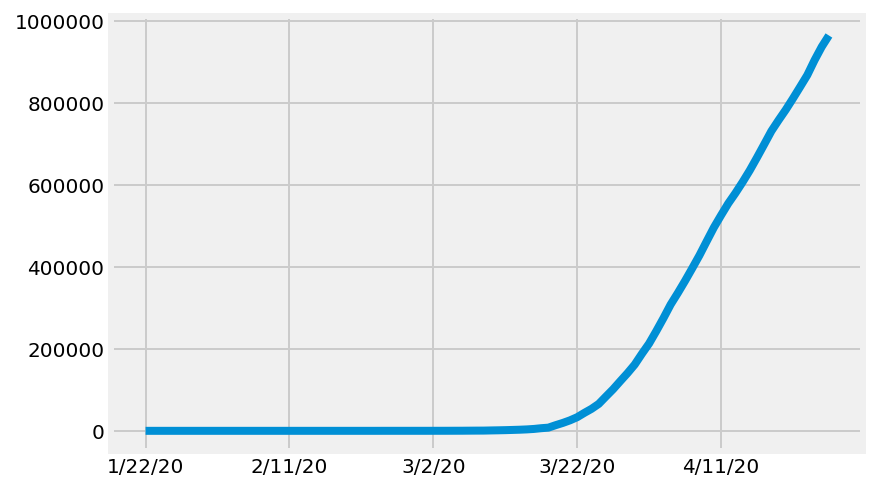

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
225        1        1        2        2        5        5        5        5   

     1/30/20  1/31/20  ...  4/17/20  4/18/20  4/19/20  4/20/20  4/21/20  \
225        5        7  ...   699706   732197   758809   784326   811865   

     4/22/20  4/23/20  4/24/20  4/25/20  4/26/20  
225   840351   869170   905358   938154   965785  

[1 rows x 96 columns]

In [6]:
# US confirmed cases
confirmed_cases = confirmed_df.loc[confirmed_df['Country/Region']=='US', '1/22/20':]
# NaN check and data plot
print('Sum of NaNs:', confirmed_cases.iloc[0,:].isna().sum())
confirmed_cases.iloc[0,:].plot()
plt.show()
confirmed_cases.head()

### Fitting data to system of ODEs using Scipy&Numpy

[integrate.odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

`integrate.odeint(func: callable(y, t, …) , y0, t, args=() …)` 

Returns: 
- `y: array, shape (len(t), len(y0))` Array containing the value of y for each desired time in t, with the initial value y0 in the first row.

[optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

`optimize.curve_fit(f(x, …), xdata, ydata, p0, bounds=() …)` 

Returns:
- `popt: array` Optimal values for the parameters so that the sum of the squared residuals of `f(xdata, *popt)` - ydata is minimized.
- `pcov2d: array` The estimated covariance of `popt`. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use `perr = np.sqrt(np.diag(pcov))`.

**Model parameters**: $\beta$, $\gamma$, $N$. **Initial conditions**: $S(0)$, $I(0)$, $R(0)$.

In [7]:
y_data = np.array(confirmed_cases.iloc[0,:], dtype=float) # confirmed cases
t_data = np.arange(y_data.shape[0], dtype=float) + 1    # day numbers

Nus = 328.2e6 # 2019 US population

def sir_model_2p(y, t, beta, gamma): # 2 unknown parameters
    S, I, R = y # y[0]: susceptible, y[1]: infectious, y[2]: removed 
    dSdt = -beta * S * I / Nus
    dIdt =  beta * S * I / Nus - gamma * I
    dRdt =  gamma * I
    return dSdt, dIdt, dRdt

def fit_odeint_2p(t, beta, gamma):
    # initial conditions (S(0)=Nus-1, I(0)=1, R(0)=0)
    ints = integrate.odeint(sir_model_2p, (Nus-1.0, 1.0, 0.0), t, args=(beta, gamma))
    return ints[:,1] + ints[:,2] # [:,1]: infectious + [:,2]: removed = confirmed cases

popt, pcov = optimize.curve_fit(fit_odeint_2p, t_data, y_data, bounds=([0,0], [np.inf,1]))
y_fitted = fit_odeint_2p(t_data, *popt)

print(f'Parameters: beta = {popt[0]:.3f}, gamma = {popt[1]:.3f}')
print(f'Basic Reproduction Number: R0 = {popt[0]/popt[1]:.3f}') # beta/gamma

Parameters: beta = 1.126, gamma = 1.000
Basic Reproduction Number: R0 = 1.126


In [8]:
# data/fit plot
def plot_fit(t, y, yfit):
    plt.figure(figsize=(7,7))
    plt.plot(t, y, linewidth=3, color='#1F77B4FF', linestyle=':', label='data')
    plt.plot(t, yfit, linewidth=3, color='#FF7F0EB2', linestyle='-', label='fit')
    plt.gca().set_facecolor('white')
    plt.gca().ticklabel_format(useMathText=True)
    plt.xticks(fontsize=16, fontname='American Typewriter')
    plt.yticks(fontsize=16, fontname='American Typewriter')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
    plt.title('US confirmed cases', fontsize=20, fontname='American Typewriter')
    plt.ylabel('cases', fontsize=18, fontname='American Typewriter')
    plt.xlabel('days', fontsize=18, fontname='American Typewriter')
    plt.legend(loc='best', prop={'family':'American Typewriter','size':'18'})
    plt.show()

Last day error: 409471.662


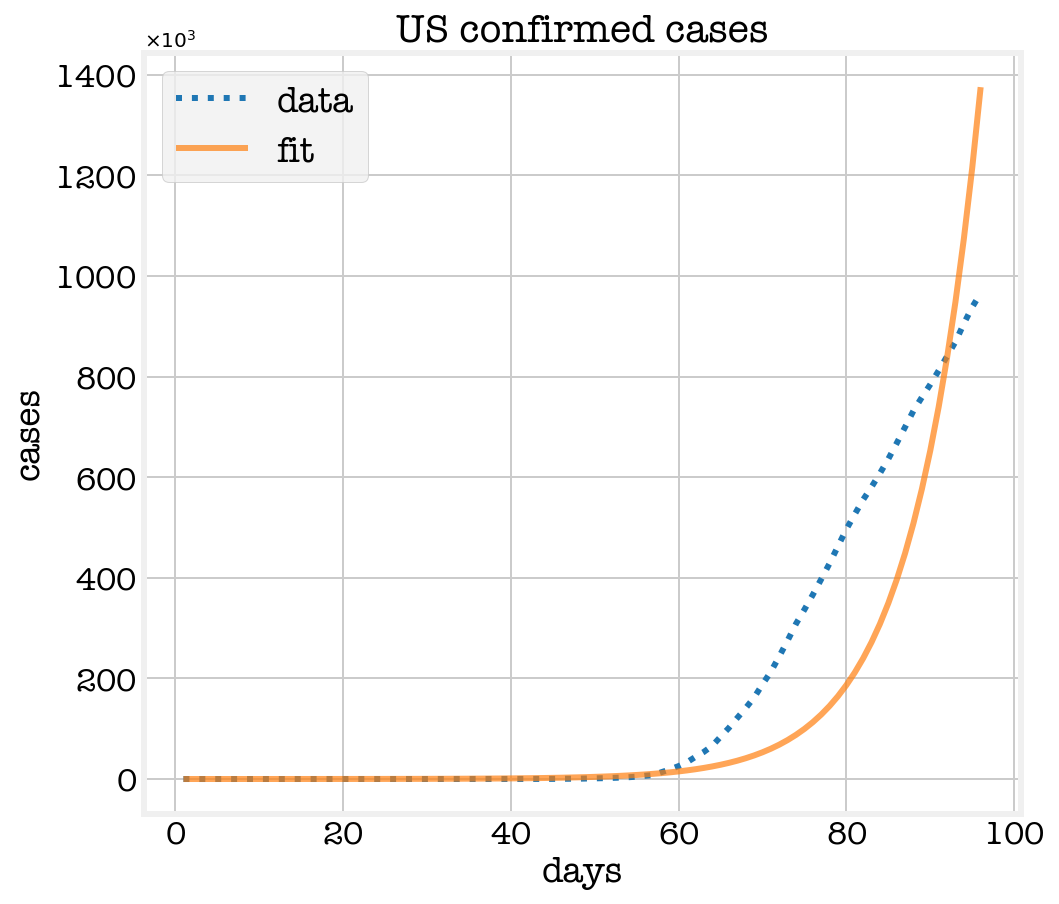

In [9]:
print(f'Last day error: {np.abs(y_data[-1]-y_fitted[-1]):.3f}')
plot_fit(t_data, y_data, y_fitted)

Bad approximation. Population size `Nus` is too big and should be changed...

Parameters: beta = 1.140, gamma = 1.000
Basic Reproduction Number: R0 = 1.140
Last day error: 161250.019


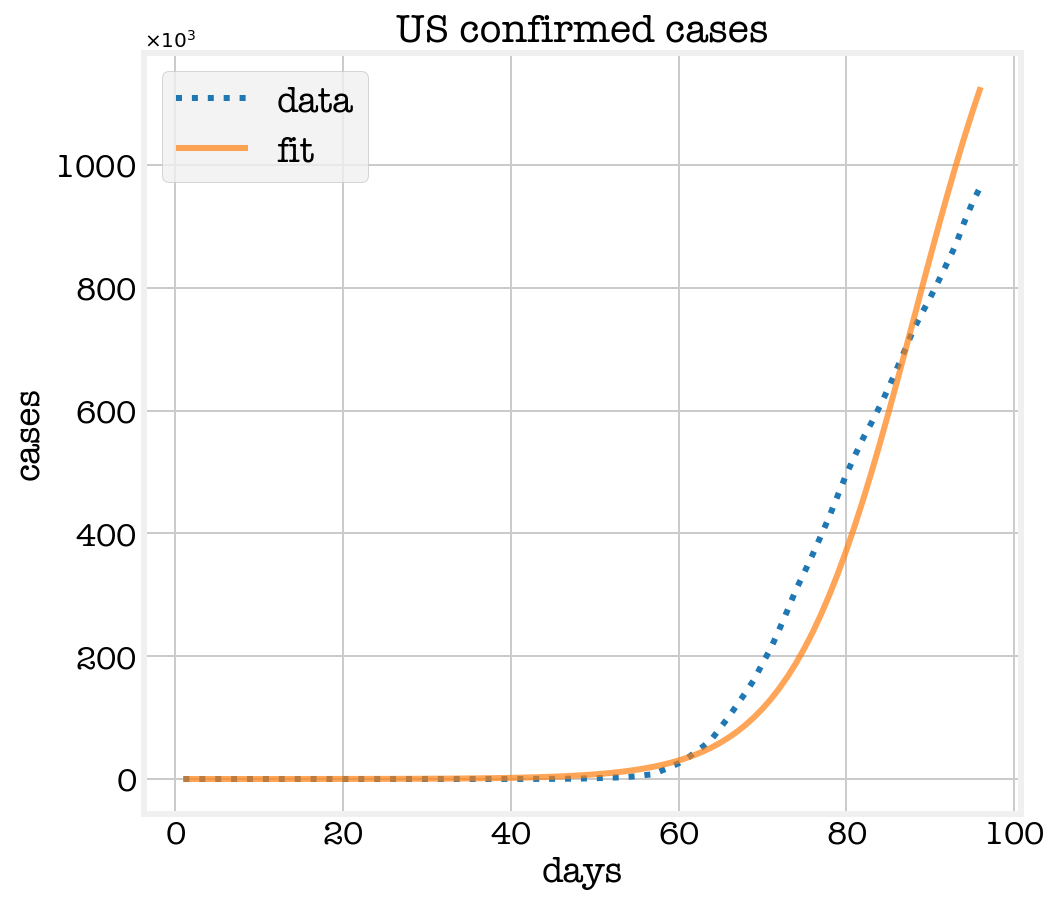

In [10]:
Nus = 328.2e6 * 0.02

popt, pcov = optimize.curve_fit(fit_odeint_2p, t_data, y_data, bounds=([0,0], [np.inf,1]))
y_fitted = fit_odeint_2p(t_data, *popt)

print(f'Parameters: beta = {popt[0]:.3f}, gamma = {popt[1]:.3f}')
print(f'Basic Reproduction Number: R0 = {popt[0]/popt[1]:.3f}')
print(f'Last day error: {np.abs(y_data[-1]-y_fitted[-1]):.3f}')

plot_fit(t_data, y_data, y_fitted)

Much better but not perfect.

Infectious peak date: 2020-04-19


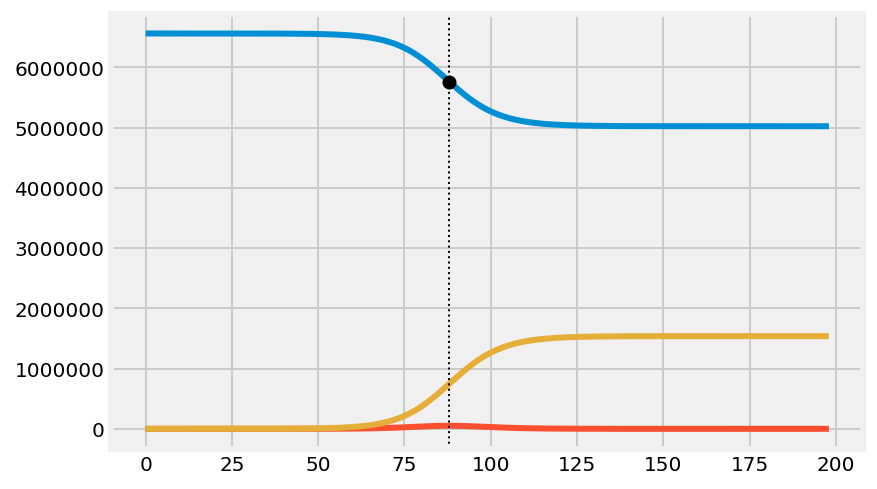

In [11]:
# SIR plots quick look
ints = integrate.odeint(sir_model_2p, (Nus-1, 1.0, 0.0), np.arange(1,200), args=(popt[0], popt[1]))

# dIdt=0 when S=N/R0=N*gamma/beta -> max I(t) infectious peak
infpeak = int(np.abs(ints[:,0] - Nus*popt[1]/popt[0]).argmin())
print('Infectious peak date:', date(2020,1,22) + relativedelta(days=infpeak))

plt.plot(ints, lw=3)
plt.plot(infpeak, ints[:,0][infpeak], marker='o', color='k')
plt.axvline(infpeak, color='k', lw=1, ls=':')
plt.show()

What about automatic optimal Nus finding?

**Bruteforce** (veeeery slow)...

Population size estimate: 4565785.00
Last day error: 487.85


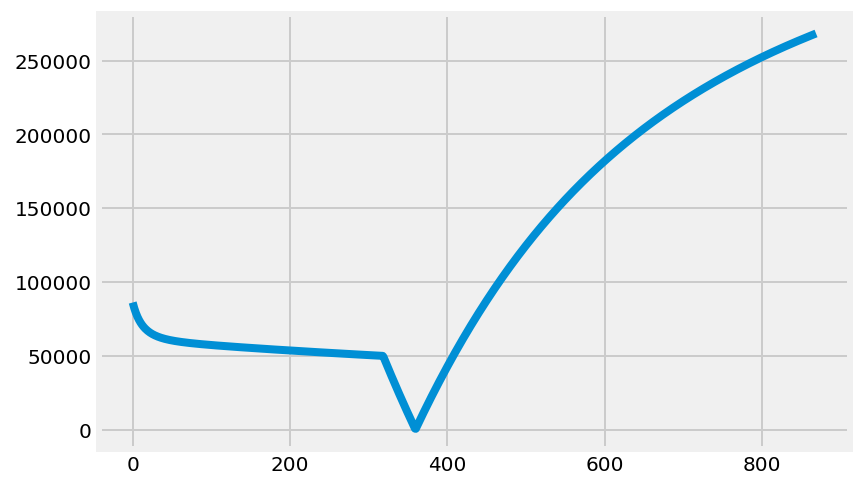

In [12]:
#popests = np.arange(y_data[-1], 50e6, 1e5)
popests = np.arange(y_data[-1], y_data[-1]*10, 1e4)
#popests = np.arange(4e6, 5e6, 1e3)
lderr = [] # last day error
for popest in popests:
    Nus = popest
    poptc, pcovc = optimize.curve_fit(fit_odeint_2p, t_data, y_data, bounds=([0,0], [np.inf,1]))
    fitc = fit_odeint_2p(t_data, *poptc)
    lderr.append(np.abs(y_data[-1] - fitc[-1]))
    
print(f'Population size estimate: {popests[np.array(lderr).argmin()]:.2f}')
print(f'Last day error: {min(lderr):.2f}')
plt.plot(lderr)
plt.show()

Parameters: beta = 1.146, gamma = 1.000
Basic Reproduction Number: R0 = 1.146
Last day error: 487.853


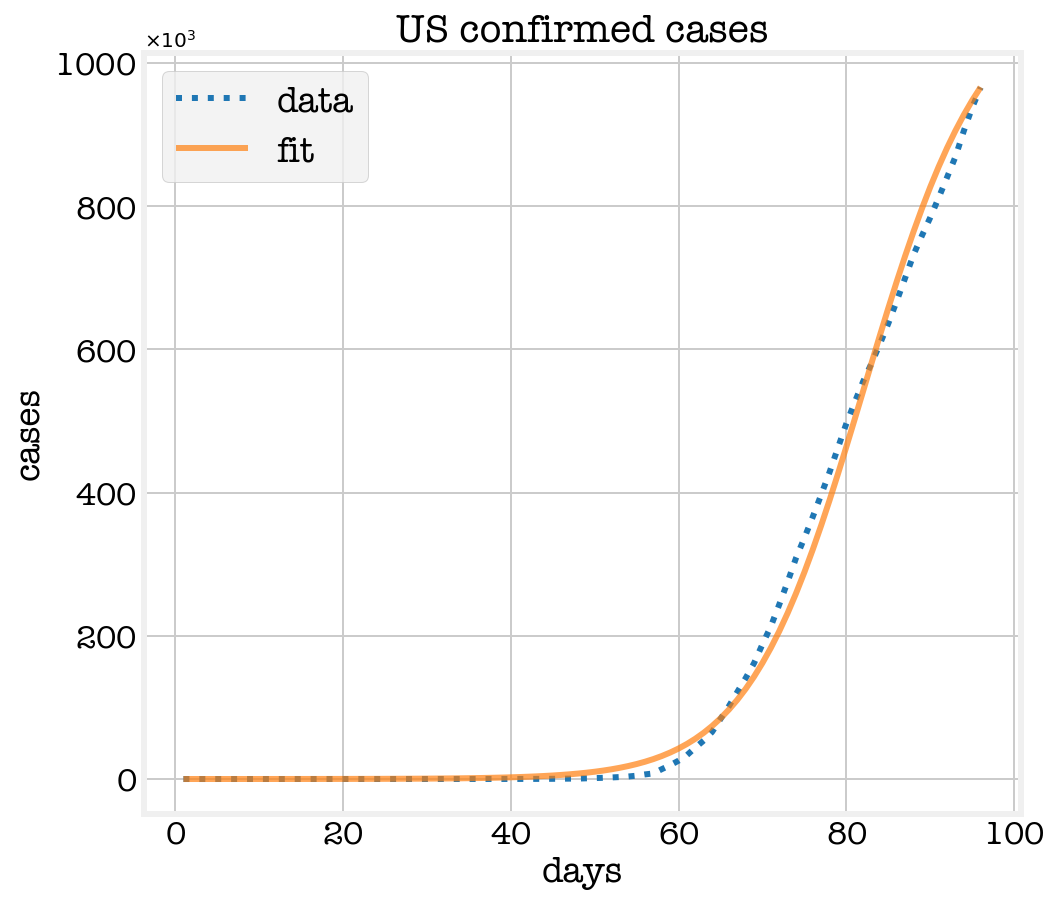

In [13]:
Nus = popests[np.array(lderr).argmin()]

popt, pcov = optimize.curve_fit(fit_odeint_2p, t_data, y_data, bounds=([0,0], [np.inf,1]))
y_fitted = fit_odeint_2p(t_data, *popt)

print(f'Parameters: beta = {popt[0]:.3f}, gamma = {popt[1]:.3f}')
print(f'Basic Reproduction Number: R0 = {popt[0]/popt[1]:.3f}')
print(f'Last day error: {np.abs(y_data[-1]-y_fitted[-1]):.3f}')

plot_fit(t_data, y_data, y_fitted)

Not bad. But how to make population size bruteforce faster? New functions `sir_model_3p` and `fit_odeint_3p`, where pop parameter is the population size. Bounds for pop we take from the data.

In [14]:
Nus = 328.2e6 # 2019 US population

def sir_model_3p(y, t, beta, gamma, pop): # 3 unknown parameters
    S, I, R = y 
    dSdt = -beta * S * I / pop
    dIdt =  beta * S * I / pop - gamma * I
    dRdt =  gamma * I
    return dSdt, dIdt, dRdt

def fit_odeint_3p(t, beta, gamma, pop):
    ints = integrate.odeint(sir_model_3p, (pop-1.0, 1.0, 0.0), t, args=(beta, gamma, pop))
    return ints[:,1] + ints[:,2]

popt, pcov = optimize.curve_fit(fit_odeint_3p, t_data, y_data, bounds=([0,0,y_data[-1]], [np.inf,1,Nus]))
y_fitted = fit_odeint_3p(t_data, *popt)

print(f'Parameters: beta = {popt[0]:.3f}, gamma = {popt[1]:.3f}, pop = {popt[2]:.3f}')
print(f'Basic Reproduction Number: R0 = {popt[0]/popt[1]:.3f}')

Parameters: beta = 1.149, gamma = 1.000, pop = 4149968.426
Basic Reproduction Number: R0 = 1.149


Last day error: 49899.298


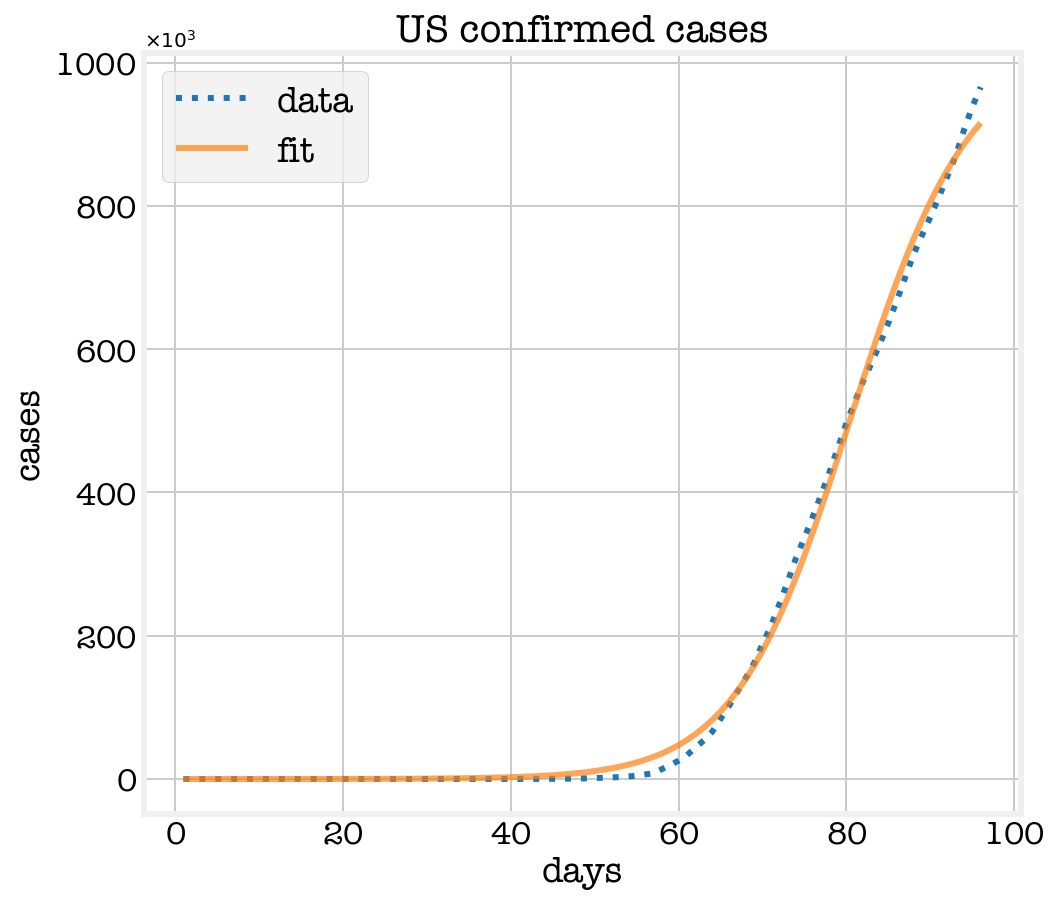

In [15]:
print(f'Last day error: {np.abs(y_data[-1]-y_fitted[-1]):.3f}')
plot_fit(t_data, y_data, y_fitted)

Looks good. But `last day error` is still big. `pop` parameter must be larger.

Infectious peak date: 2020-04-11


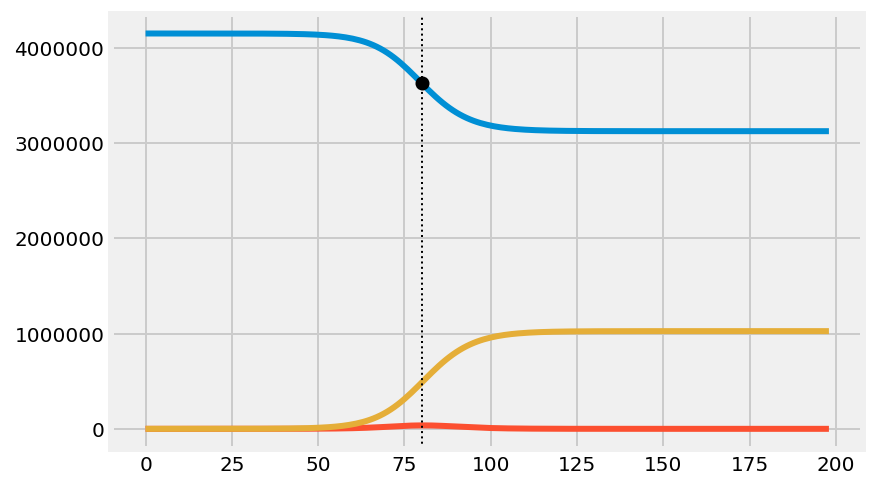

In [16]:
# SIR plots quick look
ints = integrate.odeint(sir_model_3p, (popt[2]-1, 1.0, 0.0), np.arange(1,200), args=(popt[0], popt[1], popt[2]))

# dIdt=0 when S=N/R0=N*gamma/beta -> max I(t) infectious peak
infpeak = int(np.abs(ints[:,0] - popt[2]*popt[1]/popt[0]).argmin())
print('Infectious peak date:', date(2020,1,22) + relativedelta(days=infpeak))

plt.plot(ints, lw=3)
plt.plot(infpeak, ints[:,0][infpeak], marker='o', color='k')
plt.axvline(infpeak, color='k', lw=1, ls=':')
plt.show()

### Next day predictions

Daily model training and making next day predictions.

**scipy.optimize.curve_fit info**

- `bounds` Lower and upper bounds on parameters. Defaults to no bounds. Each element of the tuple must be either an array with the length equal to the number of parameters, or a scalar (in which case the bound is taken to be the same for all parameters.) Use `np.inf` with an appropriate sign to disable bounds on all or some parameters.

- `method` Default method is `lm` for unconstrained problems and `trf` if bounds are provided. The method `lm` won’t work when the number of observations is less than the number of variables, use `trf` or `dogbox` in this case.

- `max_nfev` When bounds are specified, `curve_fit` delegates to [least_squares](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Set `max_nfev` parameter if the maximum number of function evaluations is exceeded. Maximum number of function evaluations before the termination.

### fit_odeint_2p

Making predictions with `fit_odeint_2p` model. We will train daily models based on available data and make predictions for the next day.

In [17]:
Nus = 328.2e6

# daily models and next day predictions
ndpreds = [] # next day predictions
dayfits = [] # daily fits with one day prediction
brnests = [] # R0 (BRN) estimates
daynum = 1   # first slice length (min number of observations should be not less than the number of variables for 'lm' method)
    
while daynum < y_data.shape[0]:
    t_slice, y_slice = t_data[0:daynum], y_data[0:daynum]
    poptc, pcovc = optimize.curve_fit(fit_odeint_2p, t_slice, y_slice, bounds=([0,0], [np.inf,1]))
    # max_nfev=4000 if the maximum number of function evaluations is exceeded
    fitprednd = fit_odeint_2p(t_data[0:daynum+1], *poptc) # next day prediction
    ndpreds.append(fitprednd[-1])
    dayfits.append(fitprednd)
    brnest = poptc[0]/poptc[1]
    brnests.append(brnest if brnest>1 and brnest<7 else np.nan) # covid-19 R0 could not be greater than 7
    # print log
    print(f'\ndayind: {daynum},', f'slice len: {len(t_slice)}', 
          f'\n   > date: {confirmed_cases.columns[daynum]},', 
          f'prediction for this date: {fitprednd[-1]:.2f}', 
          f'\n   > real data: {y_data[daynum]},', 
          f'error: {abs(fitprednd[-1] - y_data[daynum]):.2f}')
    daynum += 1

/Users/plokoon/.conda/envs/SARship1/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated




dayind: 1, slice len: 1 
   > date: 1/23/20, prediction for this date: 2.30 
   > real data: 1.0, error: 1.30

dayind: 2, slice len: 2 
   > date: 1/24/20, prediction for this date: 1.00 
   > real data: 2.0, error: 1.00

dayind: 3, slice len: 3 
   > date: 1/25/20, prediction for this date: 2.55 
   > real data: 2.0, error: 0.55

dayind: 4, slice len: 4 
   > date: 1/26/20, prediction for this date: 2.54 
   > real data: 5.0, error: 2.46

dayind: 5, slice len: 5 
   > date: 1/27/20, prediction for this date: 6.38 
   > real data: 5.0, error: 1.38

dayind: 6, slice len: 6 
   > date: 1/28/20, prediction for this date: 7.49 
   > real data: 5.0, error: 2.49

dayind: 7, slice len: 7 
   > date: 1/29/20, prediction for this date: 6.56 
   > real data: 5.0, error: 1.56

dayind: 8, slice len: 8 
   > date: 1/30/20, prediction for this date: 6.12 
   > real data: 5.0, error: 1.12

dayind: 9, slice len: 9 
   > date: 1/31/20, prediction for this date: 5.87 
   > real data: 7.0, error: 1.13




dayind: 72, slice len: 72 
   > date: 4/3/20, prediction for this date: 307024.75 
   > real data: 275367.0, error: 31657.75

dayind: 73, slice len: 73 
   > date: 4/4/20, prediction for this date: 344600.75 
   > real data: 308650.0, error: 35950.75

dayind: 74, slice len: 74 
   > date: 4/5/20, prediction for this date: 384354.31 
   > real data: 336802.0, error: 47552.31

dayind: 75, slice len: 75 
   > date: 4/6/20, prediction for this date: 422207.56 
   > real data: 366317.0, error: 55890.56

dayind: 76, slice len: 76 
   > date: 4/7/20, prediction for this date: 462859.47 
   > real data: 397121.0, error: 65738.47

dayind: 77, slice len: 77 
   > date: 4/8/20, prediction for this date: 513484.45 
   > real data: 428654.0, error: 84830.45

dayind: 78, slice len: 78 
   > date: 4/9/20, prediction for this date: 565671.82 
   > real data: 462780.0, error: 102891.82

dayind: 79, slice len: 79 
   > date: 4/10/20, prediction for this date: 619943.99 
   > real data: 496535.0, error:

In [18]:
# daily fits + predictions plotting
def plot_fits_preds(t, y, yfits, preds):
    plt.figure(figsize=(7,7))
    plt.plot(t, y, linewidth=3, color='#1F77B4FF', linestyle=':', label='data')
    plt.gca().set_facecolor('white')
    plt.gca().ticklabel_format(useMathText=True)
    plt.xticks(fontsize=16, fontname='American Typewriter')
    plt.yticks(fontsize=16, fontname='American Typewriter')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
    plt.title('US confirmed cases', fontsize=20, fontname='American Typewriter')
    plt.ylabel('cases', fontsize=18, fontname='American Typewriter')
    plt.xlabel('days', fontsize=18, fontname='American Typewriter')
    for yfit in yfits:
        plt.plot(t[:yfit.shape[0]], yfit[:], linewidth=1.5, color='#FF7F0E33', linestyle='-')
    plt.plot(t[1:], preds[:], linewidth=2, color='#2CA02CDD', linestyle='--', label='preds')
    plt.legend(loc='best', prop={'family':'American Typewriter','size':'18'})
    plt.show()

R0 mean: 1.39
Predictions RMSE: 151475.92


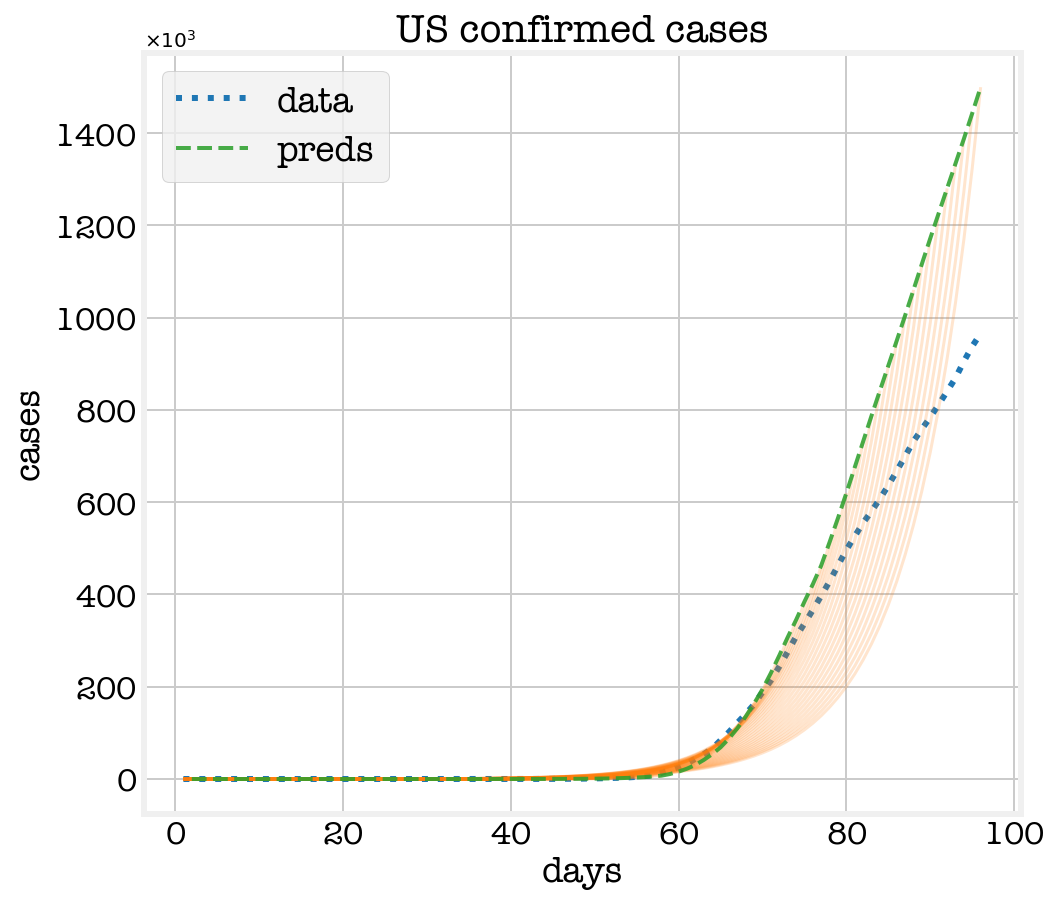

In [19]:
print(f'R0 mean: {np.array(brnests)[~np.isnan(brnests)].mean():.2f}')
print(f'Predictions RMSE: {np.sqrt(np.mean(np.square(y_data[1:]-ndpreds))):.2f}')
plot_fits_preds(t_data, y_data, dayfits, ndpreds)

Change population size and make prediction again:

In [20]:
Nus = 328.2e6*0.02

ndpreds, dayfits, brnests = [], [], []
daynum = 1 
    
while daynum < y_data.shape[0]:
    t_slice, y_slice = t_data[0:daynum], y_data[0:daynum]
    poptc, pcovc = optimize.curve_fit(fit_odeint_2p, t_slice, y_slice, bounds=([0,0], [np.inf,1]))
    fitprednd = fit_odeint_2p(t_data[0:daynum+1], *poptc) # next day prediction
    ndpreds.append(fitprednd[-1])
    dayfits.append(fitprednd)
    brnest = poptc[0]/poptc[1]
    brnests.append(brnest if brnest>1 and brnest<7 else np.nan) # covid-19 R0 could not be greater than 7
    # print log
    print(f'\ndayind: {daynum},', f'slice len: {len(t_slice)}', 
          f'\n   > date: {confirmed_cases.columns[daynum]},', 
          f'prediction for this date: {fitprednd[-1]:.2f}', 
          f'\n   > real data: {y_data[daynum]},', 
          f'error: {abs(fitprednd[-1] - y_data[daynum]):.2f}')
    daynum += 1

/Users/plokoon/.conda/envs/SARship1/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated




dayind: 1, slice len: 1 
   > date: 1/23/20, prediction for this date: 2.30 
   > real data: 1.0, error: 1.30

dayind: 2, slice len: 2 
   > date: 1/24/20, prediction for this date: 1.00 
   > real data: 2.0, error: 1.00

dayind: 3, slice len: 3 
   > date: 1/25/20, prediction for this date: 2.55 
   > real data: 2.0, error: 0.55

dayind: 4, slice len: 4 
   > date: 1/26/20, prediction for this date: 2.54 
   > real data: 5.0, error: 2.46

dayind: 5, slice len: 5 
   > date: 1/27/20, prediction for this date: 6.38 
   > real data: 5.0, error: 1.38

dayind: 6, slice len: 6 
   > date: 1/28/20, prediction for this date: 7.49 
   > real data: 5.0, error: 2.49

dayind: 7, slice len: 7 
   > date: 1/29/20, prediction for this date: 6.56 
   > real data: 5.0, error: 1.56

dayind: 8, slice len: 8 
   > date: 1/30/20, prediction for this date: 6.12 
   > real data: 5.0, error: 1.12

dayind: 9, slice len: 9 
   > date: 1/31/20, prediction for this date: 5.87 
   > real data: 7.0, error: 1.13




dayind: 71, slice len: 71 
   > date: 4/2/20, prediction for this date: 263791.93 
   > real data: 243622.0, error: 20169.93

dayind: 72, slice len: 72 
   > date: 4/3/20, prediction for this date: 304142.60 
   > real data: 275367.0, error: 28775.60

dayind: 73, slice len: 73 
   > date: 4/4/20, prediction for this date: 339826.02 
   > real data: 308650.0, error: 31176.02

dayind: 74, slice len: 74 
   > date: 4/5/20, prediction for this date: 376680.26 
   > real data: 336802.0, error: 39878.26

dayind: 75, slice len: 75 
   > date: 4/6/20, prediction for this date: 409998.98 
   > real data: 366317.0, error: 43681.98

dayind: 76, slice len: 76 
   > date: 4/7/20, prediction for this date: 441153.81 
   > real data: 397121.0, error: 44032.81

dayind: 77, slice len: 77 
   > date: 4/8/20, prediction for this date: 471284.26 
   > real data: 428654.0, error: 42630.26

dayind: 78, slice len: 78 
   > date: 4/9/20, prediction for this date: 502005.74 
   > real data: 462780.0, error: 3

R0 mean: 1.30
Predictions RMSE: 59417.43


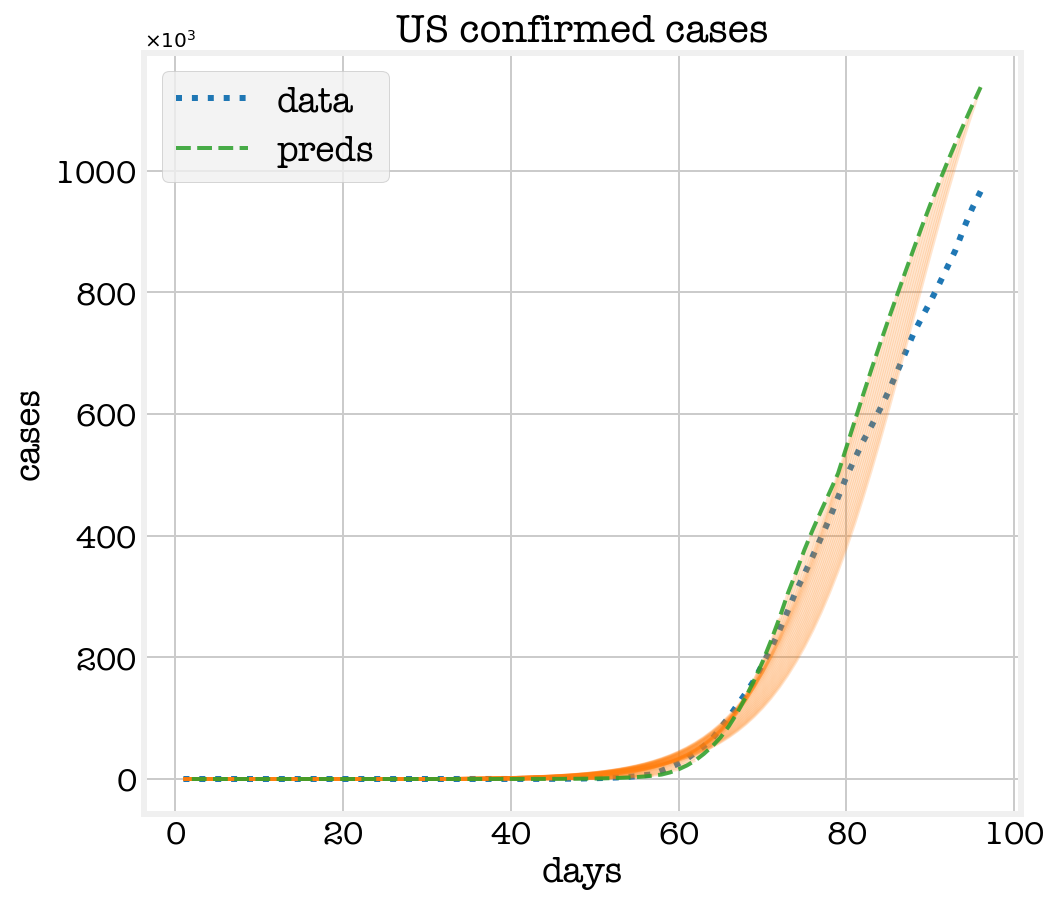

In [21]:
print(f'R0 mean: {np.array(brnests)[~np.isnan(brnests)].mean():.2f}')
print(f'Predictions RMSE: {np.sqrt(np.mean(np.square(y_data[1:]-ndpreds))):.2f}')
plot_fits_preds(t_data, y_data, dayfits, ndpreds)

Get population estimates from data (**previous day**):

In [22]:
ndpreds, dayfits, brnests = [], [], []
daynum = 1 

while daynum < y_data.shape[0]:
    t_slice, y_slice = t_data[0:daynum], y_data[0:daynum]
    Nus = y_slice[-1] # Nus estimate from data
    poptc, pcovc = optimize.curve_fit(fit_odeint_2p, t_slice, y_slice, bounds=([0,0], [np.inf,1]))
    fitprednd = fit_odeint_2p(t_data[0:daynum+1], *poptc) # next day prediction
    ndpreds.append(fitprednd[-1])
    dayfits.append(fitprednd)
    brnest = poptc[0]/poptc[1]
    brnests.append(brnest if brnest>1 and brnest<7 else np.nan) # covid-19 R0 could not be greater than 7
    # print log
    print(f'\ndayind: {daynum},', f'slice len: {len(t_slice)}', 
          f'\n   > date: {confirmed_cases.columns[daynum]},', 
          f'prediction for this date: {fitprednd[-1]:.2f}', 
          f'\n   > real data: {y_data[daynum]},', 
          f'error: {abs(fitprednd[-1] - y_data[daynum]):.2f}')
    daynum += 1

/Users/plokoon/.conda/envs/SARship1/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated




dayind: 1, slice len: 1 
   > date: 1/23/20, prediction for this date: 1.00 
   > real data: 1.0, error: 0.00

dayind: 2, slice len: 2 
   > date: 1/24/20, prediction for this date: 1.00 
   > real data: 2.0, error: 1.00

dayind: 3, slice len: 3 
   > date: 1/25/20, prediction for this date: 1.85 
   > real data: 2.0, error: 0.15

dayind: 4, slice len: 4 
   > date: 1/26/20, prediction for this date: 1.95 
   > real data: 5.0, error: 3.05

dayind: 5, slice len: 5 
   > date: 1/27/20, prediction for this date: 4.19 
   > real data: 5.0, error: 0.81

dayind: 6, slice len: 6 
   > date: 1/28/20, prediction for this date: 4.63 
   > real data: 5.0, error: 0.37

dayind: 7, slice len: 7 
   > date: 1/29/20, prediction for this date: 4.82 
   > real data: 5.0, error: 0.18

dayind: 8, slice len: 8 
   > date: 1/30/20, prediction for this date: 4.91 
   > real data: 5.0, error: 0.09

dayind: 9, slice len: 9 
   > date: 1/31/20, prediction for this date: 4.95 
   > real data: 7.0, error: 2.05




dayind: 73, slice len: 73 
   > date: 4/4/20, prediction for this date: 210088.66 
   > real data: 308650.0, error: 98561.34

dayind: 74, slice len: 74 
   > date: 4/5/20, prediction for this date: 238822.48 
   > real data: 336802.0, error: 97979.52

dayind: 75, slice len: 75 
   > date: 4/6/20, prediction for this date: 266009.18 
   > real data: 366317.0, error: 100307.82

dayind: 76, slice len: 76 
   > date: 4/7/20, prediction for this date: 294487.53 
   > real data: 397121.0, error: 102633.47

dayind: 77, slice len: 77 
   > date: 4/8/20, prediction for this date: 324238.83 
   > real data: 428654.0, error: 104415.17

dayind: 78, slice len: 78 
   > date: 4/9/20, prediction for this date: 354957.37 
   > real data: 462780.0, error: 107822.63

dayind: 79, slice len: 79 
   > date: 4/10/20, prediction for this date: 387685.34 
   > real data: 496535.0, error: 108849.66

dayind: 80, slice len: 80 
   > date: 4/11/20, prediction for this date: 420769.82 
   > real data: 526396.0, e

R0 mean: 3.96
Predictions RMSE: 52168.57


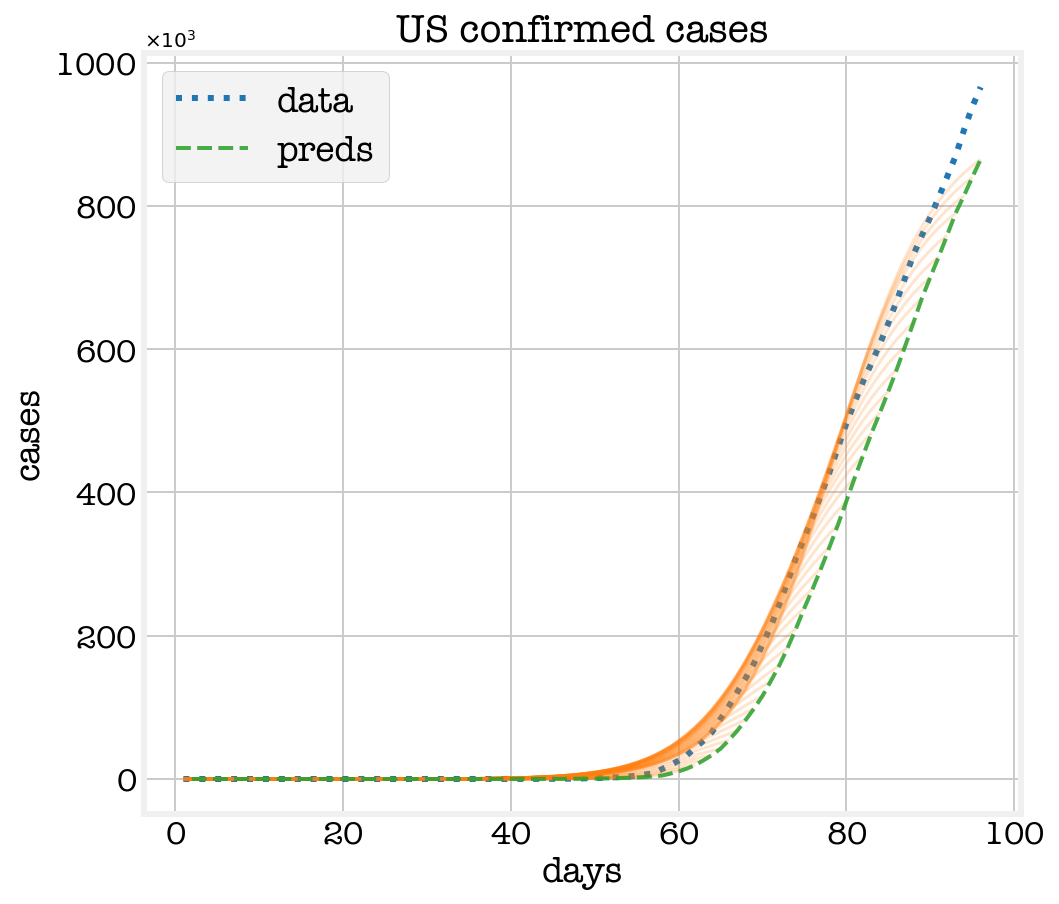

In [23]:
print(f'R0 mean: {np.array(brnests)[~np.isnan(brnests)].mean():.2f}')
print(f'Predictions RMSE: {np.sqrt(np.mean(np.square(y_data[1:]-ndpreds))):.2f}')
plot_fits_preds(t_data, y_data, dayfits, ndpreds)

Get population estimates from data (**previous day**) + **bruteforce** (slowest solution!)

In [24]:
ndpreds, dayfits, brnests = [], [], []
daynum = 2

while daynum < y_data.shape[0]:
    t_slice, y_slice = t_data[0:daynum], y_data[0:daynum]
    
    popests = np.arange(y_slice[-2], y_slice[-2]*10, 1e4) # Nus bruteforce
    prederr = []
    for popest in popests:
        Nus = popest
        poptc, pcovc = optimize.curve_fit(fit_odeint_2p, t_slice[:-1], y_slice[:-1], bounds=([0,0], [np.inf,1]))
        fitc = fit_odeint_2p(t_slice, *poptc) # predict current day
        prederr.append(np.abs(y_slice[-1] - fitc[-1]))
    Nus = popests[np.array(prederr).argmin()]
    poptc, pcovc = optimize.curve_fit(fit_odeint_2p, t_slice, y_slice, bounds=([0,0], [np.inf,1]))
    fitprednd = fit_odeint_2p(t_data[0:daynum+1], *poptc) # next day prediction
    ndpreds.append(fitprednd[-1])
    dayfits.append(fitprednd)
    brnest = poptc[0]/poptc[1]
    brnests.append(brnest if brnest>1 and brnest<7 else np.nan) # covid-19 R0 could not be greater than 7
    # print log
    print(f'\ndayind: {daynum},', f'slice len: {len(t_slice)}', 
          f'\n   > date: {confirmed_cases.columns[daynum]},', 
          f'prediction for this date: {fitprednd[-1]:.2f}', 
          f'\n   > real data: {y_data[daynum]},', 
          f'error: {abs(fitprednd[-1] - y_data[daynum]):.2f}')
    daynum += 1

/Users/plokoon/.conda/envs/SARship1/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated




dayind: 2, slice len: 2 
   > date: 1/24/20, prediction for this date: 1.00 
   > real data: 2.0, error: 1.00

dayind: 3, slice len: 3 
   > date: 1/25/20, prediction for this date: 1.00 
   > real data: 2.0, error: 1.00

dayind: 4, slice len: 4 
   > date: 1/26/20, prediction for this date: 1.95 
   > real data: 5.0, error: 3.05

dayind: 5, slice len: 5 
   > date: 1/27/20, prediction for this date: 2.00 
   > real data: 5.0, error: 3.00

dayind: 6, slice len: 6 
   > date: 1/28/20, prediction for this date: 4.63 
   > real data: 5.0, error: 0.37

dayind: 7, slice len: 7 
   > date: 1/29/20, prediction for this date: 4.82 
   > real data: 5.0, error: 0.18

dayind: 8, slice len: 8 
   > date: 1/30/20, prediction for this date: 4.91 
   > real data: 5.0, error: 0.09

dayind: 9, slice len: 9 
   > date: 1/31/20, prediction for this date: 4.95 
   > real data: 7.0, error: 2.05

dayind: 10, slice len: 10 
   > date: 2/1/20, prediction for this date: 4.98 
   > real data: 8.0, error: 3.02



dayind: 72, slice len: 72 
   > date: 4/3/20, prediction for this date: 278495.91 
   > real data: 275367.0, error: 3128.91

dayind: 73, slice len: 73 
   > date: 4/4/20, prediction for this date: 311782.74 
   > real data: 308650.0, error: 3132.74

dayind: 74, slice len: 74 
   > date: 4/5/20, prediction for this date: 345967.24 
   > real data: 336802.0, error: 9165.24

dayind: 75, slice len: 75 
   > date: 4/6/20, prediction for this date: 371508.40 
   > real data: 366317.0, error: 5191.40

dayind: 76, slice len: 76 
   > date: 4/7/20, prediction for this date: 399613.40 
   > real data: 397121.0, error: 2492.40

dayind: 77, slice len: 77 
   > date: 4/8/20, prediction for this date: 428002.98 
   > real data: 428654.0, error: 651.02

dayind: 78, slice len: 78 
   > date: 4/9/20, prediction for this date: 458685.79 
   > real data: 462780.0, error: 4094.21

dayind: 79, slice len: 79 
   > date: 4/10/20, prediction for this date: 493751.82 
   > real data: 496535.0, error: 2783.18


R0 mean: 2.87
Predictions RMSE: 6329.79


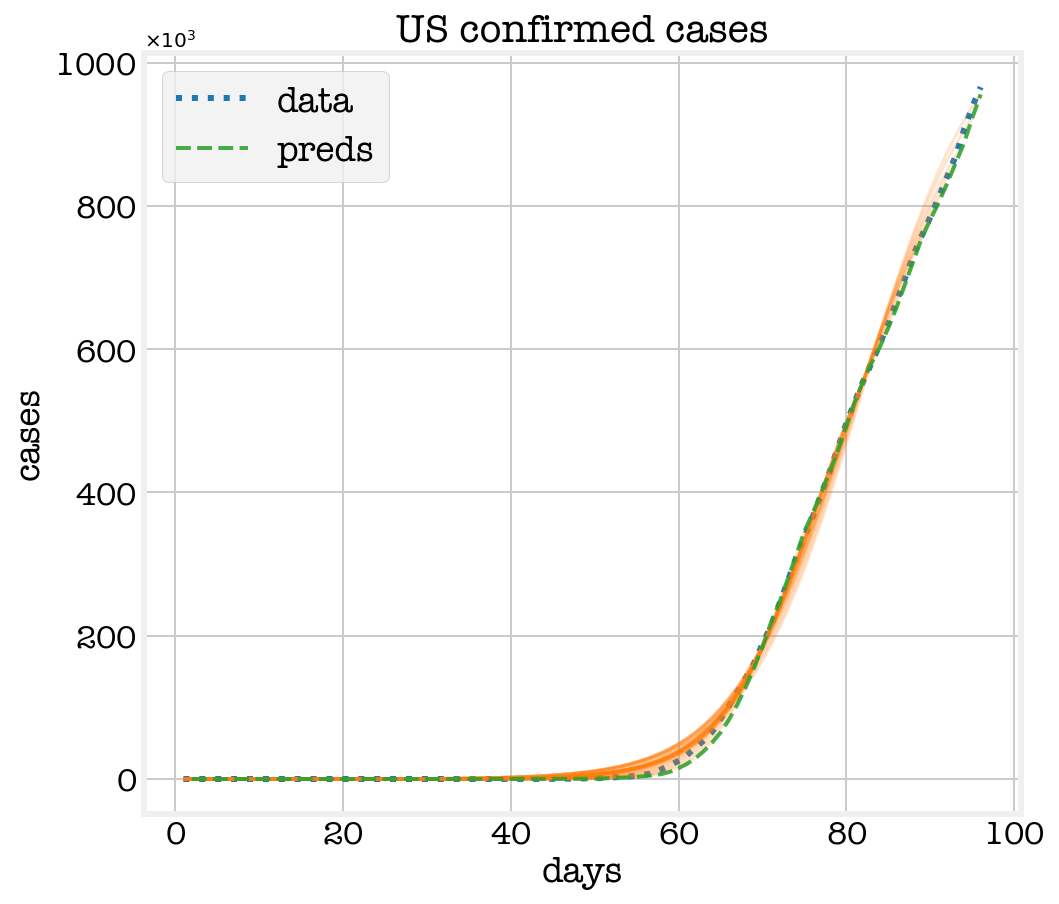

In [25]:
print(f'R0 mean: {np.array(brnests)[~np.isnan(brnests)].mean():.2f}')
print(f'Predictions RMSE: {np.sqrt(np.mean(np.square(y_data[2:]-ndpreds))):.2f}')
plot_fits_preds(t_data, y_data, dayfits, [0]+ndpreds) # because init daynum = 2

### fit_odeint_3p

Making predictions with `fit_odeint_3p` model.

In [26]:
Nus = 328.2e6

ndpreds = [] # next day predictions
dayfits = [] # daily fits with one day prediction
brnests = [] # R0 (BRN) estimates
popests = [] # pop estimates
daynum = 1
    
while daynum < y_data.shape[0]:
    t_slice, y_slice = t_data[0:daynum], y_data[0:daynum]
    left, right = y_slice[-1], Nus # pop parameter bounds
    poptc, pcovc = optimize.curve_fit(fit_odeint_3p, t_slice, y_slice, bounds=([0,0,left], [np.inf,1,right]))
    # max_nfev=4000 if the maximum number of function evaluations is exceeded
    fitprednd = fit_odeint_3p(t_data[0:daynum+1], *poptc) # next day prediction
    ndpreds.append(fitprednd[-1])
    dayfits.append(fitprednd)
    brnest = poptc[0]/poptc[1]
    brnests.append(brnest if brnest>1 and brnest<7 else np.nan) # covid-19 R0 could not be greater than 7
    popests.append(poptc[2] if poptc[2]>left and poptc[2]<right else np.nan)
    # print log
    print(f'\ndayind: {daynum},', f'slice len: {len(t_slice)}', 
          f'\n   > date: {confirmed_cases.columns[daynum]},', 
          f'prediction for this date: {fitprednd[-1]:.2f}', 
          f'\n   > real data: {y_data[daynum]},', 
          f'error: {abs(fitprednd[-1] - y_data[daynum]):.2f}')
    daynum += 1

/Users/plokoon/.conda/envs/SARship1/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated




dayind: 1, slice len: 1 
   > date: 1/23/20, prediction for this date: 2.30 
   > real data: 1.0, error: 1.30

dayind: 2, slice len: 2 
   > date: 1/24/20, prediction for this date: 1.11 
   > real data: 2.0, error: 0.89

dayind: 3, slice len: 3 
   > date: 1/25/20, prediction for this date: 2.55 
   > real data: 2.0, error: 0.55

dayind: 4, slice len: 4 
   > date: 1/26/20, prediction for this date: 2.41 
   > real data: 5.0, error: 2.59

dayind: 5, slice len: 5 
   > date: 1/27/20, prediction for this date: 6.38 
   > real data: 5.0, error: 1.38

dayind: 6, slice len: 6 
   > date: 1/28/20, prediction for this date: 6.93 
   > real data: 5.0, error: 1.93

dayind: 7, slice len: 7 
   > date: 1/29/20, prediction for this date: 6.56 
   > real data: 5.0, error: 1.56

dayind: 8, slice len: 8 
   > date: 1/30/20, prediction for this date: 6.12 
   > real data: 5.0, error: 1.12

dayind: 9, slice len: 9 
   > date: 1/31/20, prediction for this date: 5.87 
   > real data: 7.0, error: 1.13




dayind: 71, slice len: 71 
   > date: 4/2/20, prediction for this date: 250476.95 
   > real data: 243622.0, error: 6854.95

dayind: 72, slice len: 72 
   > date: 4/3/20, prediction for this date: 294971.81 
   > real data: 275367.0, error: 19604.81

dayind: 73, slice len: 73 
   > date: 4/4/20, prediction for this date: 334036.16 
   > real data: 308650.0, error: 25386.16

dayind: 74, slice len: 74 
   > date: 4/5/20, prediction for this date: 356028.60 
   > real data: 336802.0, error: 19226.60

dayind: 75, slice len: 75 
   > date: 4/6/20, prediction for this date: 385371.97 
   > real data: 366317.0, error: 19054.97

dayind: 76, slice len: 76 
   > date: 4/7/20, prediction for this date: 413335.83 
   > real data: 397121.0, error: 16214.83

dayind: 77, slice len: 77 
   > date: 4/8/20, prediction for this date: 441036.87 
   > real data: 428654.0, error: 12382.87

dayind: 78, slice len: 78 
   > date: 4/9/20, prediction for this date: 468727.44 
   > real data: 462780.0, error: 59

R0 mean: 1.85
Pop mean: 158018885.08
Predictions RMSE: 16568.49


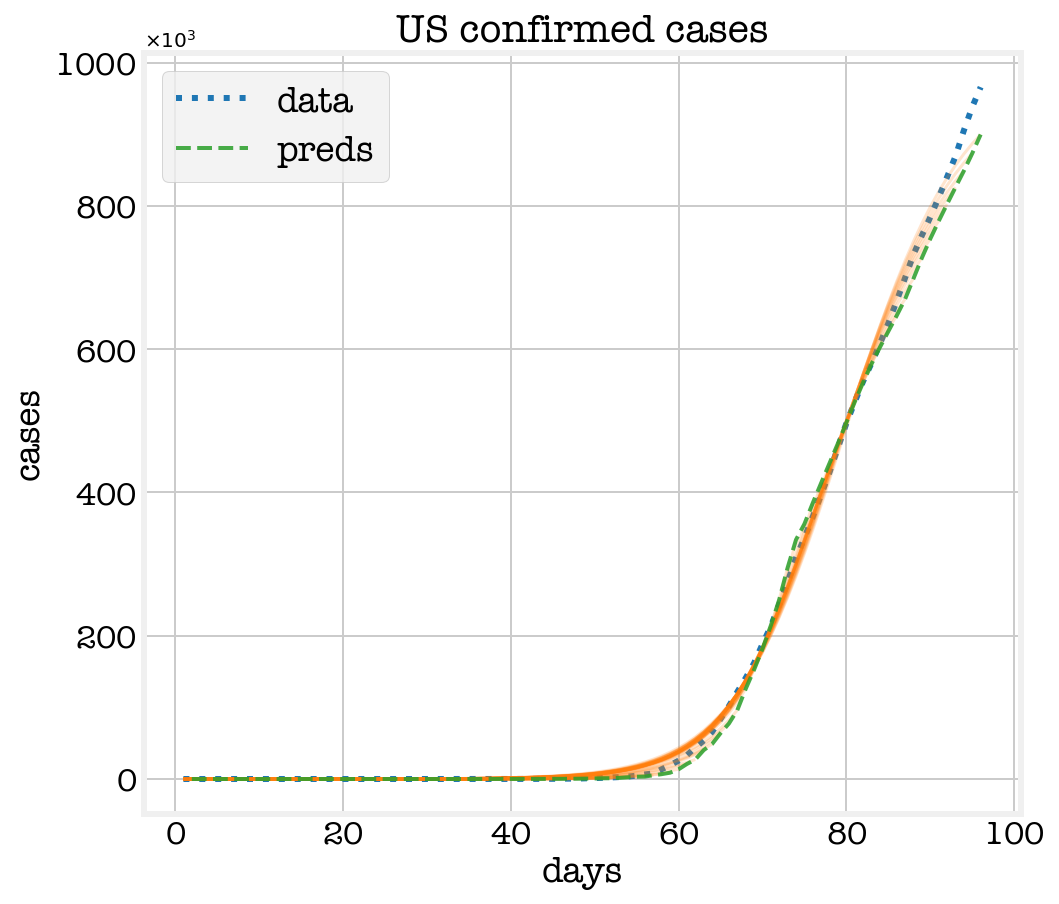

In [27]:
print(f'R0 mean: {np.array(brnests)[~np.isnan(brnests)].mean():.2f}')
print(f'Pop mean: {np.array(popests)[~np.isnan(popests)].mean():.2f}')
print(f'Predictions RMSE: {np.sqrt(np.mean(np.square(y_data[1:]-ndpreds))):.2f}')
plot_fits_preds(t_data, y_data, dayfits, ndpreds)

Last days confirmed cases are underestimated. It's time for some empirical strategies:

In [28]:
Nus = 328.2e6

ndpreds, dayfits, brnests, popests = [], [], [], []
daynum = 1
    
while daynum < y_data.shape[0]:
    t_slice, y_slice = t_data[0:daynum], y_data[0:daynum]
    left, right = y_slice[-1]*5, y_slice[-1]*10 # pop parameter bounds
    poptc, pcovc = optimize.curve_fit(fit_odeint_3p, t_slice, y_slice, bounds=([0,0,left], [np.inf,1,right]))
    fitprednd = fit_odeint_3p(t_data[0:daynum+1], *poptc) # next day prediction
    ndpreds.append(fitprednd[-1])
    dayfits.append(fitprednd)
    brnest = poptc[0]/poptc[1]
    brnests.append(brnest if brnest>1 and brnest<7 else np.nan) # covid-19 R0 could not be greater than 7
    popests.append(poptc[2] if poptc[2]>left and poptc[2]<right else np.nan)
    # print log
    print(f'\ndayind: {daynum},', f'slice len: {len(t_slice)}', 
          f'\n   > date: {confirmed_cases.columns[daynum]},', 
          f'prediction for this date: {fitprednd[-1]:.2f}', 
          f'\n   > real data: {y_data[daynum]},', 
          f'error: {abs(fitprednd[-1] - y_data[daynum]):.2f}')
    daynum += 1

/Users/plokoon/.conda/envs/SARship1/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated




dayind: 1, slice len: 1 
   > date: 1/23/20, prediction for this date: 1.95 
   > real data: 1.0, error: 0.95

dayind: 2, slice len: 2 
   > date: 1/24/20, prediction for this date: 1.00 
   > real data: 2.0, error: 1.00

dayind: 3, slice len: 3 
   > date: 1/25/20, prediction for this date: 2.51 
   > real data: 2.0, error: 0.51

dayind: 4, slice len: 4 
   > date: 1/26/20, prediction for this date: 2.53 
   > real data: 5.0, error: 2.47

dayind: 5, slice len: 5 
   > date: 1/27/20, prediction for this date: 6.17 
   > real data: 5.0, error: 1.17

dayind: 6, slice len: 6 
   > date: 1/28/20, prediction for this date: 7.08 
   > real data: 5.0, error: 2.08

dayind: 7, slice len: 7 
   > date: 1/29/20, prediction for this date: 6.46 
   > real data: 5.0, error: 1.46

dayind: 8, slice len: 8 
   > date: 1/30/20, prediction for this date: 6.06 
   > real data: 5.0, error: 1.06

dayind: 9, slice len: 9 
   > date: 1/31/20, prediction for this date: 5.81 
   > real data: 7.0, error: 1.19




dayind: 71, slice len: 71 
   > date: 4/2/20, prediction for this date: 255882.35 
   > real data: 243622.0, error: 12260.35

dayind: 72, slice len: 72 
   > date: 4/3/20, prediction for this date: 291245.04 
   > real data: 275367.0, error: 15878.04

dayind: 73, slice len: 73 
   > date: 4/4/20, prediction for this date: 327343.49 
   > real data: 308650.0, error: 18693.49

dayind: 74, slice len: 74 
   > date: 4/5/20, prediction for this date: 363695.07 
   > real data: 336802.0, error: 26893.07

dayind: 75, slice len: 75 
   > date: 4/6/20, prediction for this date: 397789.07 
   > real data: 366317.0, error: 31472.07

dayind: 76, slice len: 76 
   > date: 4/7/20, prediction for this date: 428307.29 
   > real data: 397121.0, error: 31186.29

dayind: 77, slice len: 77 
   > date: 4/8/20, prediction for this date: 457088.90 
   > real data: 428654.0, error: 28434.90

dayind: 78, slice len: 78 
   > date: 4/9/20, prediction for this date: 488004.60 
   > real data: 462780.0, error: 2

R0 mean: 1.57
Pop mean: 922196.81
Predictions RMSE: 10841.57


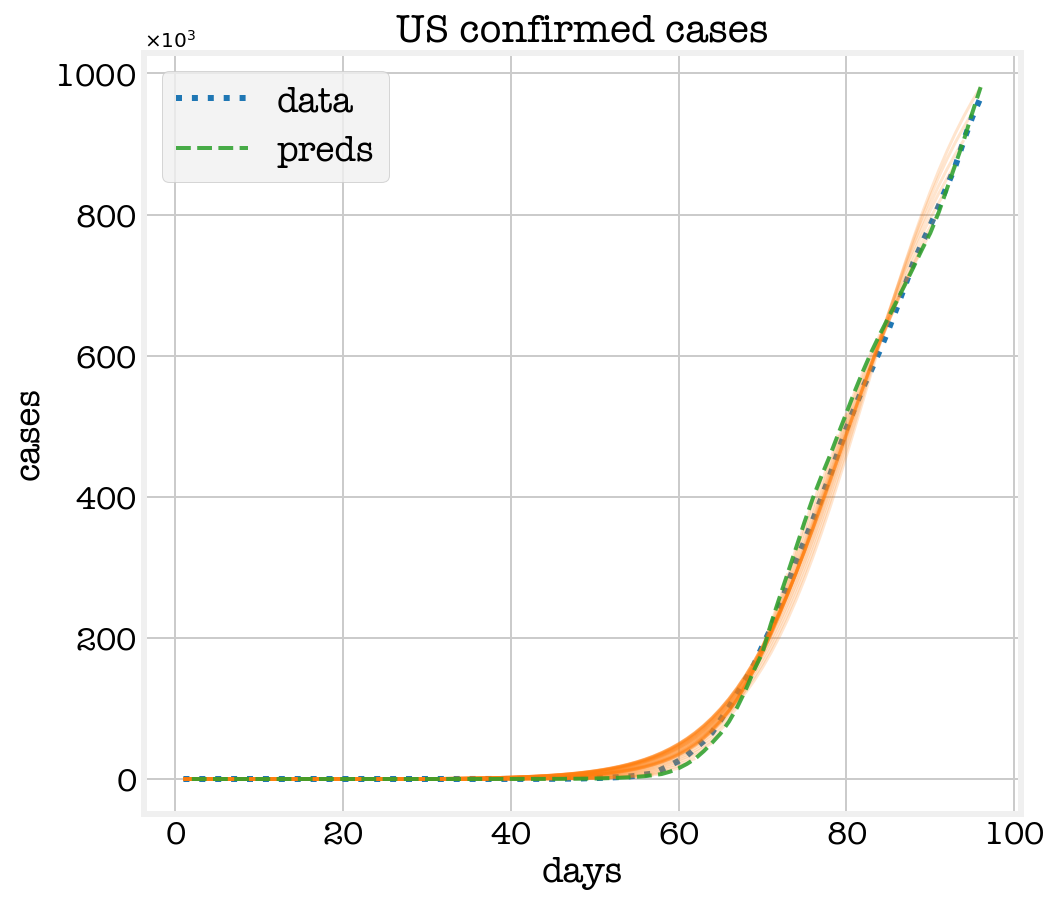

In [29]:
print(f'R0 mean: {np.array(brnests)[~np.isnan(brnests)].mean():.2f}')
print(f'Pop mean: {np.array(popests)[~np.isnan(popests)].mean():.2f}')
print(f'Predictions RMSE: {np.sqrt(np.mean(np.square(y_data[1:]-ndpreds))):.2f}')
plot_fits_preds(t_data, y_data, dayfits, ndpreds)

Let's try your own strategies for free :)